In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import fnmatch
import os
import kuka_utils as u
from datetime import datetime
import sys


In [2]:
file_path = '/Volumes/bigLacie/processed_stare_new_nrcs/'




In [3]:
date_list = ['20191107','20191114','20191220','20191226',
             '20200102','20200107','20200109',
             '20200112','20200116',
             '20200119','20200123','20200124','20200129','20200130']

band = ['Ku', 'Ka']
pols = ['vv','vh','hv','hh']
threshold =  0.0001
vreduc = .8 

#set coords where transects are
areas = u.areas()

In [7]:
b = 'Ku'
date = '20191107'
nf_files = fnmatch.filter(os.listdir(file_path),'kuka_stare*'+b+'*'+date+'*.nc')
ds = nc.Dataset(file_path + nf_files[0])
print(ds)
ds.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: KuKa combined echo and summary data
    use_permission: Permission of project PI (Prof. Julienne Stroeve j.stroeve@ucl.ac.uk) is required to access, analyse and publish data before 1st January 2023. See MOSAiC Data Policy https://mosaic-expedition.org/wp-content/uploads/2020/12/mosaic_datapolicy.pdf.
    assistance: For data processing assistance, contact Dr. Rosemary Willatt (r.willatt@ucl.ac.uk) (Stare Mode), Dr. Vishnu Nandan (vishnu.nandan@umanitoba.ca) (Scan Mode), Dr Thomas Newman (t.newman@ucl.ac.uk) (Deconvolution)
    file_processed_with: KuKaPy translated from ProSensing IDL code by Vishnu Nandan with additions by Rosemary Willatt and Thomas Newman
    file_created_by: Willatt UCL
    date_created: 20221215
    data_type: KuKaPy output
    kuka_operators: Stefan Hendricks, Gunnar Spreen and Oguz Demir (leg 1), Julienne Stroeve, Vishnu Nandan, Rasmus Tonboe and Marcus Huntemann (le

//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """


In [6]:
#CS2 Alt version map out the KuKa data locations for all dates and create x_y_p files
file_path = '/Volumes/bigLacie/processed_stare_cs2_alt_new_nrcs/'
# for date in date_list:
for date in ['20200112']:
    print(date)
    f = plt.figure(figsize = (10,10))
    for b in band:
        nf_files = fnmatch.filter(os.listdir(file_path),'kuka_stare*'+b+'*'+date+'*.nc')   
        nf_files.sort()
        x_y_p = {'x':[],
                'y':[],
                'cross_tilt':[],
                'along_tilt':[],
                'start_time':[]}
        for p in pols:
            x_y_p[p+'_decon0'] = []
        print('x_y_p', x_y_p)
        if len(nf_files) > 0:
            for nf in nf_files:
                print('nf:', file_path + nf)
                ds = nc.Dataset(file_path + nf)

    #             print('now using FLOENAVI to correct ice drift')
                # Allow to find icedrift 
                # NOTE: this only works if `floenavi` (this module) and `icedrift` are cloned to the same directory
                # sys.path.append('Users⁩/rosie⁩/Documents⁩/code⁩/python⁩/')
                sys.path.append('../icedrift/')

                from icedrift import GeoReferenceStation, IceCoordinateSystem, GeoPositionData

                #ref files for leg 1 and 2
                if min(ds['start_time']) < 1582588800: #leg 1 and 2
                    'correcting Ka band data for ice drift using floenavi'
                    if min(ds['start_time']) < 1576281600:
                        leg = 1
                        refstat_csv_file = r"../floenavi/data/master-solution/mosaic-leg1-20191016-20191213-floenavi-refstat-v1p0.csv"
                    elif (min(ds['start_time']) >= 1576281600) & (min(ds['start_time']) < 1582588800):
                        leg = 2
                        refstat_csv_file = r"../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv"

                    print('refstat csv file: ', refstat_csv_file)
                    refstat = GeoReferenceStation.from_csv(refstat_csv_file)
                    icecs = IceCoordinateSystem(refstat)    

                    start_time = [datetime.fromtimestamp(t) for t in ds['start_time']]
                    dt64 = pd.to_datetime(start_time)
                    time = u.dt64todt(dt64.values)

                    pos = GeoPositionData(time, ds['lon'], ds['lat'])
                    icepos = icecs.get_xy_coordinates(pos)
                    x0 = icepos.xc
                    y0 = icepos.yc

                    x_y_p['x'].extend(x0)
                    x_y_p['y'].extend(y0)
            
                    x_y_p['along_tilt'].extend(ds['along_tilt'])
                    x_y_p['cross_tilt'].extend(ds['cross_tilt'])
                    x_y_p['start_time'].extend(ds['start_time'])

                    for p in pols:
                        x_y_p[p+'_decon0'].append(ds[p+'_power_decon0'][:])

                    plt.plot(x0, y0, label = nf, marker = '.', markersize = .5)
                    if nf == nf_files[0]:
                        x_y_p['range'] = ds['range'][:]

                ds.close()


            plt.legend(loc = 'upper right', bbox_to_anchor = (1.53, 1))
            axes = plt.gca()
            axes.set_aspect('equal')
            plt.show()

            f = plt.figure(figsize = (10,10))
            plt.plot(x_y_p['x'], x_y_p['y'], 'm.', markersize = .5)        
            axes = plt.gca()
            axes.set_aspect('equal')
            plt.show()

            for p in pols:
                x_y_p[p+'_decon0'] = np.concatenate(x_y_p[p+'_decon0'], axis = 1)
            

            pickle.dump(x_y_p, open(file_path + '/x_y_p/x_y_p_'+date+'_'+b+'.p', 'wb'))





20200112
x_y_p {'x': [], 'y': [], 'cross_tilt': [], 'along_tilt': [], 'start_time': [], 'vv_decon0': [], 'vh_decon0': [], 'hv_decon0': [], 'hh_decon0': []}


<Figure size 720x720 with 0 Axes>

20200124
x_y_p {'x': [], 'y': [], 'cross_tilt': [], 'along_tilt': [], 'start_time': [], 'vv': [], 'vv_decon0': [], 'vh': [], 'vh_decon0': [], 'hv': [], 'hv_decon0': [], 'hh': [], 'hh_decon0': []}
nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-112134.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-112634.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-113134.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-113634.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-114135.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-114635.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-115135.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-115635.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-120135.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-120635.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-121135.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-121635.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-122135.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-122636.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-123136.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-123636.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-124136.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-124636.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-125136.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-125636.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-130136.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-130636.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-131137.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-131637.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-132137.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-132637.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-133137.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-133637.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ku-Scat20200124-134137.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

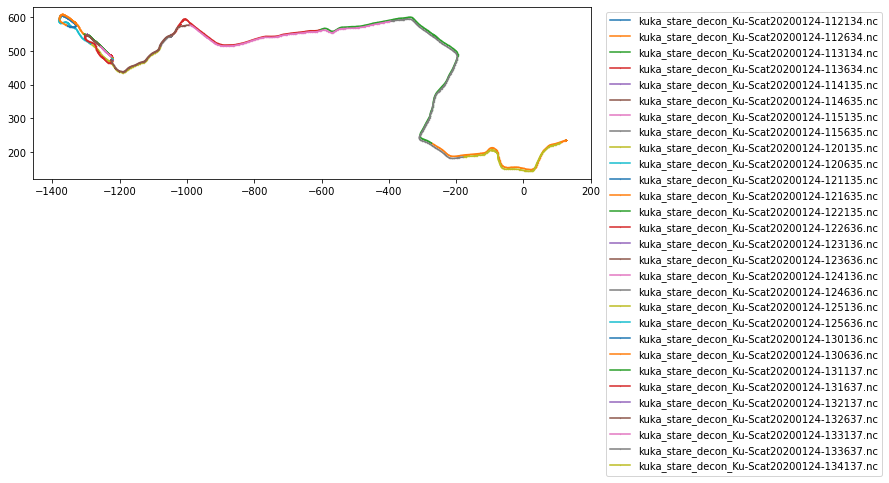

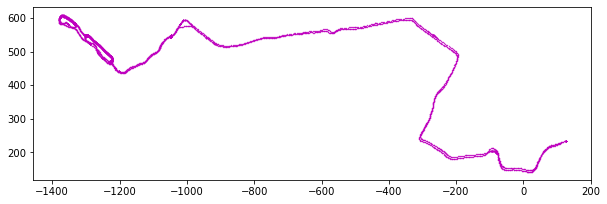

x_y_p {'x': [], 'y': [], 'cross_tilt': [], 'along_tilt': [], 'start_time': [], 'vv': [], 'vv_decon0': [], 'vh': [], 'vh_decon0': [], 'hv': [], 'hv_decon0': [], 'hh': [], 'hh_decon0': []}
nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-112134.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-112635.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-113135.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-113635.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-114135.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-114635.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-115136.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-115636.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-120136.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-120636.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-121137.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-121637.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-122137.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-122637.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-123137.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-123638.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-124138.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-124638.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-125138.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-125639.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-130139.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-130639.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-131139.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-131639.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-132140.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-132640.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-133140.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-133640.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-134141.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

nf: /Volumes/bigLacie/processed_stare_new_nrcs/kuka_stare_decon_Ka-Scat20200124-155543.nc


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.b

refstat csv file:  ../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv


//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/envs/icesat2/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.b

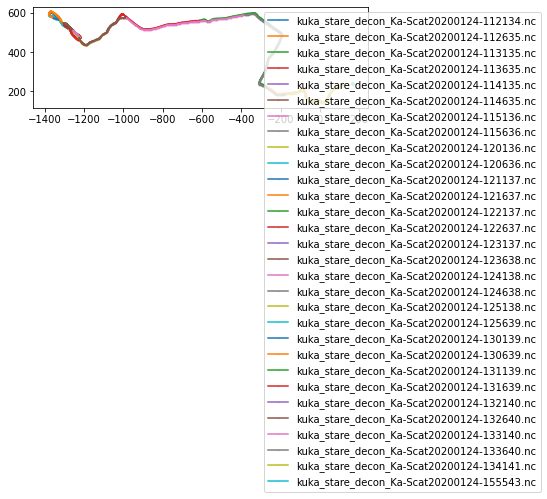

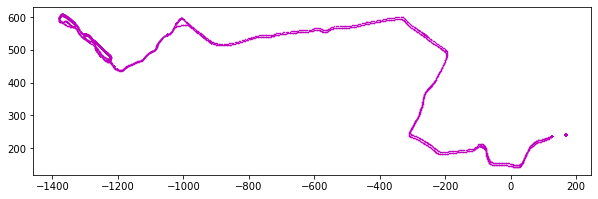

In [13]:
#map out the KuKa data locations for all dates and create x_y_p files FULL BW NEW WAVEFORMS

# file_path = '/Volumes/bigLacie/processed_stare_new_waveforms/'
file_path = '/Volumes/bigLacie/processed_stare_new_nrcs/'


# for date in date_list:
for date in ['20200124']:
    print(date)
    f = plt.figure(figsize = (10,10))
    for b in band:
#         print('kuka_stare*'+b+'*'+date+'*.nc')
        nf_files = fnmatch.filter(os.listdir(file_path),'kuka_stare*'+b+'*'+date+'*.nc')   
        nf_files.sort()
        x_y_p = {'x':[],
                'y':[],
                'cross_tilt':[],
                'along_tilt':[],
                'start_time':[]}
        for p in pols:
            x_y_p[p] = []
            x_y_p[p+'_decon0'] = []
        print('x_y_p', x_y_p)
        if len(nf_files) > 0:
            for nf in nf_files:
                print('nf:', file_path + nf)
                ds = nc.Dataset(file_path + nf)

    #             print('now using FLOENAVI to correct ice drift')
                # Allow to find icedrift 
                # NOTE: this only works if `floenavi` (this module) and `icedrift` are cloned to the same directory
                # sys.path.append('Users⁩/rosie⁩/Documents⁩/code⁩/python⁩/')
                sys.path.append('../icedrift/')

                from icedrift import GeoReferenceStation, IceCoordinateSystem, GeoPositionData

                #ref files for leg 1 and 2
                if min(ds['start_time']) < 1582588800: #leg 1 and 2
                    'correcting Ka band data for ice drift using floenavi'
                    if min(ds['start_time']) < 1576281600:
                        leg = 1
                        refstat_csv_file = r"../floenavi/data/master-solution/mosaic-leg1-20191016-20191213-floenavi-refstat-v1p0.csv"
                    elif (min(ds['start_time']) >= 1576281600) & (min(ds['start_time']) < 1582588800):
                        leg = 2
                        refstat_csv_file = r"../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv"

                    print('refstat csv file: ', refstat_csv_file)
                    refstat = GeoReferenceStation.from_csv(refstat_csv_file)
                    icecs = IceCoordinateSystem(refstat)    

                    start_time = [datetime.fromtimestamp(t) for t in ds['start_time']]
                    dt64 = pd.to_datetime(start_time)
                    time = u.dt64todt(dt64.values)
                    
#                     print('time',time)
#                     print('lat',ds['lat'][:])
#                     print('lon',ds['lon'][:])

                    pos = GeoPositionData(time, ds['lon'], ds['lat'])
                    icepos = icecs.get_xy_coordinates(pos)
                    x0 = icepos.xc
                    y0 = icepos.yc

                    x_y_p['x'].extend(x0)
                    x_y_p['y'].extend(y0)
            
                    x_y_p['along_tilt'].extend(ds['along_tilt'])
                    x_y_p['cross_tilt'].extend(ds['cross_tilt'])
                    x_y_p['start_time'].extend(ds['start_time'])

                    for p in pols:
                        x_y_p[p].append(ds[p+'_power'][:])
                        x_y_p[p+'_decon0'].append(ds[p+'_power_decon0'][:])

                    plt.plot(x0, y0, label = nf, marker = '.', markersize = .5)
                    if nf == nf_files[0]:
                        x_y_p['range'] = ds['range'][:]

                ds.close()


            plt.legend(loc = 'upper right', bbox_to_anchor = (1.53, 1))
            axes = plt.gca()
            axes.set_aspect('equal')
            plt.show()

            f = plt.figure(figsize = (10,10))
            plt.plot(x_y_p['x'], x_y_p['y'], 'm.', markersize = .5)        
            axes = plt.gca()
            axes.set_aspect('equal')
            plt.show()

            for p in pols:
                x_y_p[p] = np.concatenate(x_y_p[p], axis = 1)
                x_y_p[p+'_decon0'] = np.concatenate(x_y_p[p+'_decon0'], axis = 1)
            

            pickle.dump(x_y_p, open(file_path + '/x_y_p/x_y_p_'+date+'_'+b+'.p', 'wb'))


